# **Introduction**

***

<p style="font-size:18px;"> This case study will explore the fruit and vegetable image dataset with the goal of creating a classification model which is at least 95% accurate. The dataset contains 3825 images which have been split into training, testing and validation folders.
    
<p style="font-size:18px;"> The model could be used to help visually impaired people identify fruit and vegetables and teach children different fruit and vegetables through taking a photo.
    
<p style="font-size:18px;"> In this case study I will be using the following pre-trained models to determine which model gives the best results. The models I will be using are as follows:
<ul style="font-size:18px;"><li> EfficientNetB0
    <li> MobileNetV3
    <li> InceptionV3</ul>  

In [1]:
# Importing relevant libaries

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0, MobileNetV3Large, InceptionV3

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Storing each directory in a variable

train_dir = "/kaggle/input/fruit-and-vegetable-image-recognition/train"
test_dir = "/kaggle/input/fruit-and-vegetable-image-recognition/test"
val_dir = "/kaggle/input/fruit-and-vegetable-image-recognition/validation"

In [3]:
# Function to convert the directories into pandas dataframes

def dir_to_df(data_dir):
    image_paths = []
    labels = []
    
    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            image_paths.append(img_path)
            labels.append(class_label)
    
    return pd.DataFrame({'image': image_paths, 'label': labels})

In [4]:
# Applying the function to convert the directories to dataframes

train_df = dir_to_df(train_dir)
val_df = dir_to_df(val_dir)
test_df = dir_to_df(test_dir)

# Printing the head of the training data

train_df.head()

,image,label
0,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum
1,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum
2,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum
3,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum
4,/kaggle/input/fruit-and-vegetable-image-recogn...,capsicum


In [5]:
# Storing all the uniques classes in a variable and counting the number of unique classes

unique_classes = train_df['label'].unique()
print(f"Unique classes: \n {unique_classes} \n \n Number of unique classes: {len(unique_classes)}")

Unique classes: 
 ['capsicum' 'sweetcorn' 'orange' 'tomato' 'turnip' 'ginger' 'raddish'
 'pomegranate' 'pineapple' 'jalepeno' 'apple' 'carrot' 'lettuce'
 'bell pepper' 'eggplant' 'beetroot' 'kiwi' 'pear' 'cabbage' 'cauliflower'
 'paprika' 'lemon' 'sweetpotato' 'grapes' 'cucumber' 'corn' 'banana'
 'garlic' 'chilli pepper' 'watermelon' 'mango' 'peas' 'onion' 'potato'
 'spinach' 'soy beans'] 
 
 Number of unique classes: 36


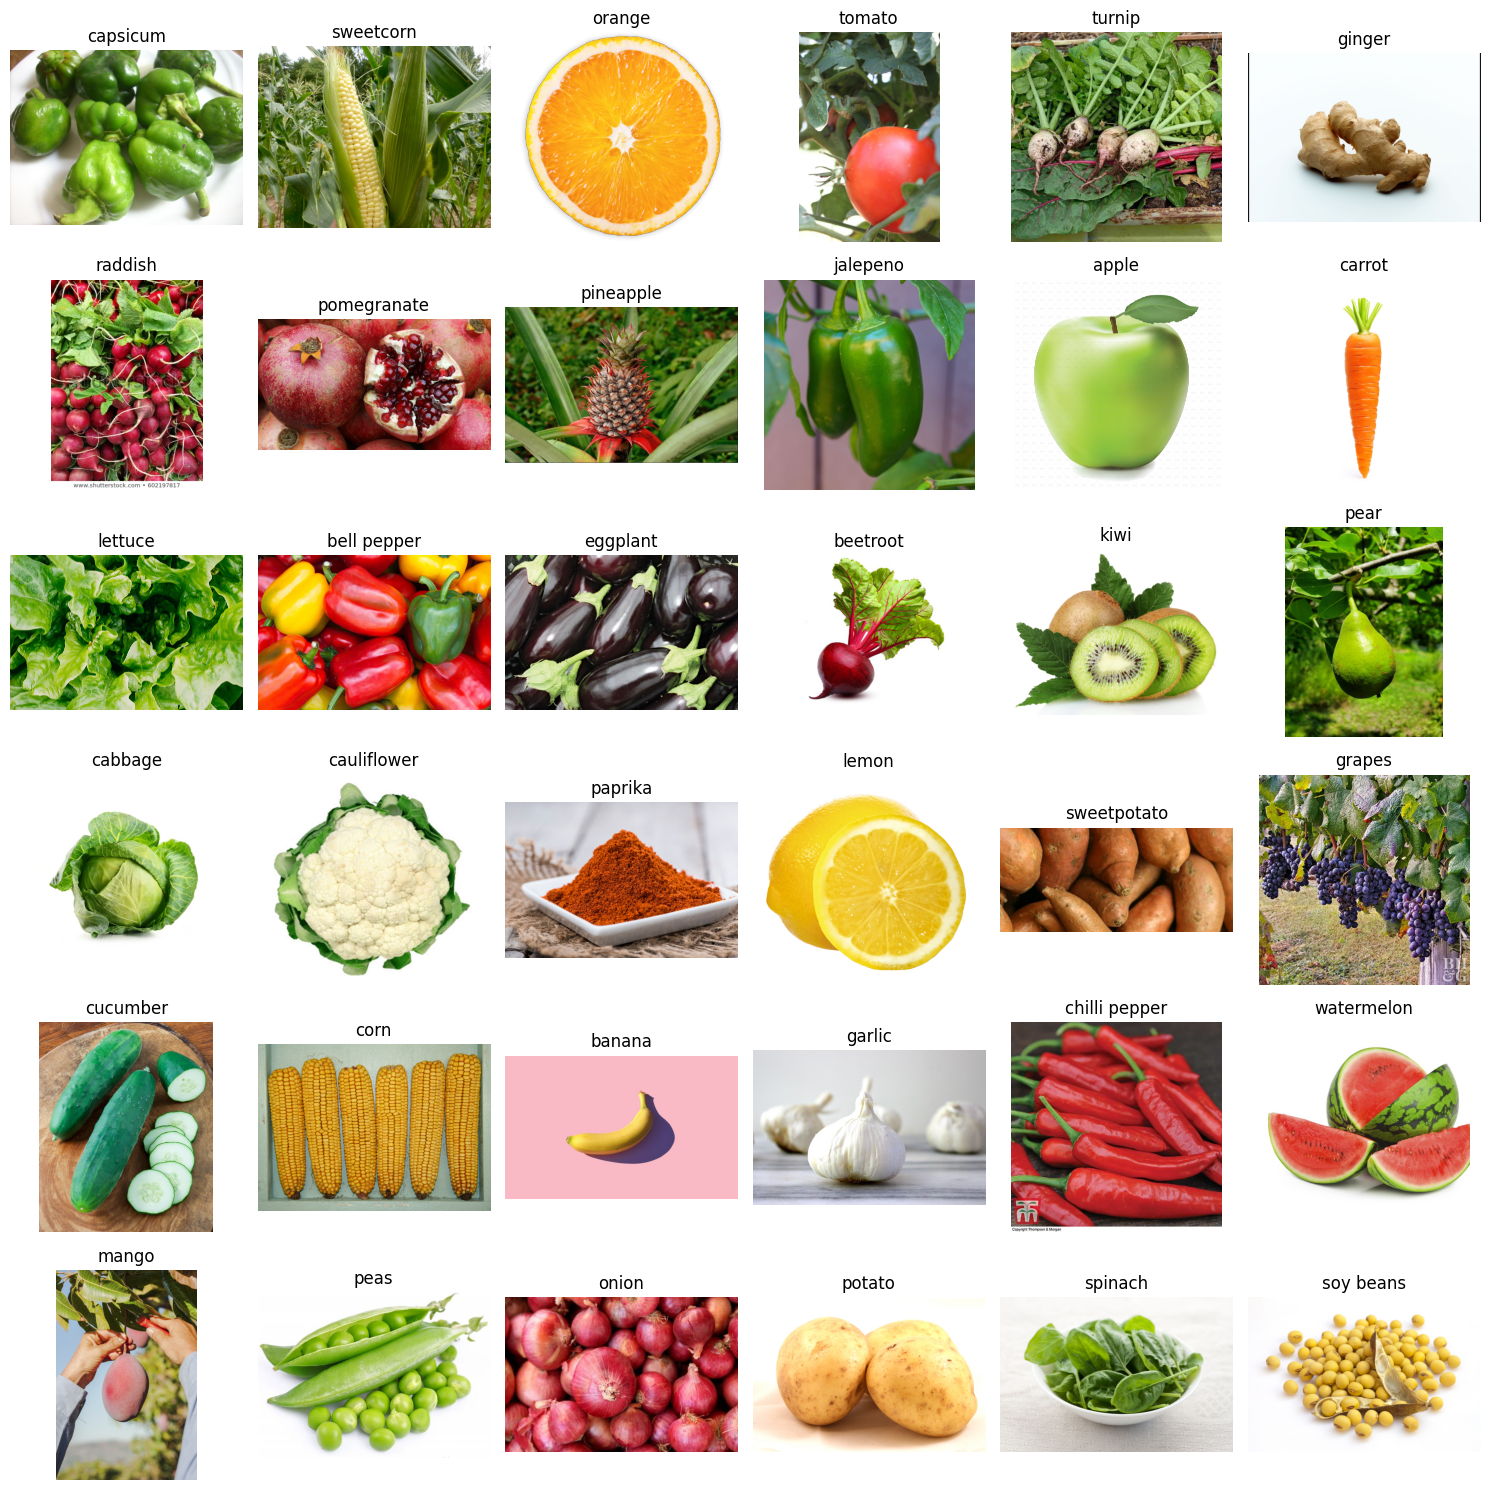

In [6]:
# Plot to show an image from each class to ensure the data is correct and loaded

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))
axes = axes.flatten()

for i, class_label in enumerate(unique_classes):
    img_path = train_df[train_df['label'] == class_label].iloc[0]['image']
    axes[i].imshow(plt.imread(img_path))
    axes[i].set_title(class_label)
    axes[i].axis('off')

plt.tight_layout()

# **EfficientNetB0**

***

In [7]:
# Creating generators for the training and testing images

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [8]:
# Function to generate augmented images from a dataframe using a wide range of transformations

def generator(train_generator, df):
    aug_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
    return aug_images

train_images = generator(train_generator, train_df)
val_images = generator(train_generator, val_df)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    shuffle=False)

Found 3115 validated image filenames belonging to 36 classes.
Found 351 validated image filenames belonging to 36 classes.
Found 359 validated image filenames belonging to 36 classes.


In [9]:
# Load the pre-trained model excluding the top layer

ENB0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base model

ENB0_model.trainable = False

# Creating a sequential model

ENB0 = models.Sequential([
    ENB0_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(unique_classes), activation='softmax')])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Compiling the model

ENB0.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
# Training the model using the training and validation images for 10 epochs

history = ENB0.fit(train_images, validation_data=val_images, epochs=10)

Epoch 1/10


I0000 00:00:1726064186.070760      73 service.cc:145] XLA service 0x788e54013880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726064186.070805      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726064186.070808      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/98 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.0469 - loss: 3.6147    

I0000 00:00:1726064206.483249      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.4618 - loss: 2.2564 - val_accuracy: 0.8917 - val_loss: 0.3763
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 110s 832ms/step - accuracy: 0.8565 - loss: 0.5007 - val_accuracy: 0.9373 - val_loss: 0.2461
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 802ms/step - accuracy: 0.9009 - loss: 0.3437 - val_accuracy: 0.9430 - val_loss: 0.1965
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 801ms/step - accuracy: 0.9226 - loss: 0.2596 - val_accuracy: 0.9402 - val_loss: 0.1733
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 804ms/step - accuracy: 0.9404 - loss: 0.1934 - val_accuracy: 0.9373 - val_loss: 0.1666
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 773ms/step - accuracy: 0.9537 - loss: 0.1543 - val_accuracy: 0.9687 - val_loss: 0.1362
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 780ms/step - accuracy: 0.9641 - loss: 0.1261 - val_accuracy: 0.9516 - val_loss: 0.1415
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 801ms/step - accuracy: 0.9753 - loss: 0.1074 - val_accuracy: 0.9573

In [12]:
# Evaluating the model

test_loss, test_acc = ENB0.evaluate(test_images)

12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9662 - loss: 0.1059


In [13]:
# Function to plot accuracy and loss

def acc_loss_plot(history):
    # Convert history.history to a DataFrame
    history_df = pd.DataFrame(history.history)

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Accuracy", "Loss"))

    # Add Accuracy Plot --------------------------------------------------------------------------------
    fig.add_trace(go.Scatter(x=history_df.index, y=history_df['accuracy'],
        mode='lines+markers',name='Training Accuracy', hovertemplate='Epoch: %{x}<br>Accuracy: %{y:.4f}<extra></extra>' ))

    fig.add_trace(go.Scatter(x=history_df.index, y=history_df['val_accuracy'],
        mode='lines+markers',name='Validation Accuracy', hovertemplate='Epoch: %{x}<br>Validation Accuracy: %{y:.4f}<extra></extra>'))

    # Add Loss Plot -----------------------------------------------------------------------------------
    fig.add_trace(go.Scatter(x=history_df.index,y=history_df['loss'],
        mode='lines+markers',name='Training Loss',hovertemplate='Epoch: %{x}<br>Loss: %{y:.4f}<extra></extra>'), row=1, col=2)

    fig.add_trace(go.Scatter(x=history_df.index,y=history_df['val_loss'],
        mode='lines+markers',name='Validation Loss',hovertemplate='Epoch: %{x}<br>Validation Loss: %{y:.4f}<extra></extra>'), row=1, col=2)

    # Update layout ----------------------------------------------------------------------------------
    fig.update_layout(title='Accuracy and Loss Curves',xaxis_title='Epoch',xaxis2_title='Epoch',
        yaxis_title='Accuracy',yaxis2_title='Loss')
    
    fig.show()
    
acc_loss_plot(history)

In [14]:
# Predict labels for test set

y_true = test_images.classes
y_pred = ENB0.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


In [15]:
# Generate and print a classification report

report = classification_report(y_true, y_pred, target_names=unique_classes)
print(report)

               precision    recall  f1-score   support

     capsicum       0.89      0.80      0.84        10
    sweetcorn       1.00      0.89      0.94         9
       orange       1.00      1.00      1.00        10
       tomato       0.89      0.80      0.84        10
       turnip       1.00      1.00      1.00        10
       ginger       0.82      0.90      0.86        10
      raddish       1.00      0.90      0.95        10
  pomegranate       1.00      1.00      1.00        10
    pineapple       1.00      1.00      1.00        10
     jalepeno       1.00      0.40      0.57        10
        apple       1.00      1.00      1.00        10
       carrot       1.00      1.00      1.00        10
      lettuce       1.00      1.00      1.00        10
  bell pepper       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
     beetroot       0.83      1.00      0.91        10
         kiwi       1.00      1.00      1.00        10
         

In [16]:
 # Function for creating a confusion matrix
    
def com_mat(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(test_images.class_indices.values()))

    # Create a DataFrame for easier plotting with Plotly
    cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

    hovertext = 'Predicted: %{x} <br> Actual: %{y} <br> No. of predictions: %{z}<extra></extra>'

    # Create a heatmap using Plotly
    fig = go.Figure(data=go.Heatmap(z=cm_df.values,x=cm_df.columns,y=cm_df.columns,
        colorscale='Blues',colorbar=dict(title='Correct Predicitions'), hovertemplate=hovertext))

    # Update layout to add titles, labels, and figure size
    fig.update_layout(title='Confusion Matrix',xaxis_title='Predicted Label',yaxis_title='True Label',
                    width=1100,height=1000, xaxis=dict(tickangle=-55))
    
    fig.show()
    
com_mat(y_true, y_pred)

# **MobileNetV3**

***

In [17]:
# Creating generators for the training and testing images

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input)

In [18]:
# Using previously created function to generate augmented images from a dataframe using a wide range of transformations

train_images = generator(train_generator, train_df)
val_images = generator(train_generator, val_df)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    shuffle=False)

Found 3115 validated image filenames belonging to 36 classes.
Found 351 validated image filenames belonging to 36 classes.
Found 359 validated image filenames belonging to 36 classes.


In [19]:
# Load the pre-trained model excluding the top layer

MNV3_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base model

MNV3_model.trainable = False

# Creating a sequential model

MNV3 = models.Sequential([
    MNV3_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(unique_classes), activation='softmax')])

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
# Compiling the model

MNV3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
# Training the model using the training and validation images for 10 epochs

history = MNV3.fit(train_images, validation_data=val_images, epochs=10)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 109s 932ms/step - accuracy: 0.4338 - loss: 2.2827 - val_accuracy: 0.8775 - val_loss: 0.3985
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 798ms/step - accuracy: 0.8492 - loss: 0.5001 - val_accuracy: 0.9259 - val_loss: 0.2472
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 807ms/step - accuracy: 0.9141 - loss: 0.3011 - val_accuracy: 0.9288 - val_loss: 0.2349
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 806ms/step - accuracy: 0.9455 - loss: 0.1893 - val_accuracy: 0.9373 - val_loss: 0.2124
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 801ms/step - accuracy: 0.9613 - loss: 0.1359 - val_accuracy: 0.9459 - val_loss: 0.1816
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 140s 790ms/step - accuracy: 0.9723 - loss: 0.1054 - val_accuracy: 0.9573 - val_loss: 0.1667
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 807ms/step - accuracy: 0.9833 - loss: 0.0740 - val_accuracy: 0.9658 - val_loss: 0.1613
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 84s 815ms/step - accuracy: 0.9829 - loss: 0.0656 - val_ac

In [22]:
# Evaluating the model
test_loss, test_acc = MNV3.evaluate(test_images)

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9661 - loss: 0.1380


In [23]:
# Using previously defined function to plot accuracy and loss
acc_loss_plot(history)

In [24]:
# Predict labels for test set

y_true = test_images.classes
y_pred = MNV3.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


In [25]:
# Generate and print a classification report

report = classification_report(y_true, y_pred, target_names=unique_classes)
print(report)

               precision    recall  f1-score   support

     capsicum       0.88      0.70      0.78        10
    sweetcorn       0.88      0.78      0.82         9
       orange       1.00      1.00      1.00        10
       tomato       1.00      1.00      1.00        10
       turnip       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
      raddish       0.90      0.90      0.90        10
  pomegranate       1.00      1.00      1.00        10
    pineapple       0.91      1.00      0.95        10
     jalepeno       0.83      1.00      0.91        10
        apple       1.00      1.00      1.00        10
       carrot       1.00      1.00      1.00        10
      lettuce       1.00      1.00      1.00        10
  bell pepper       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
     beetroot       1.00      1.00      1.00        10
         kiwi       1.00      1.00      1.00        10
         

In [26]:
# Using previously defined function to plot a confusion matrix

com_mat(y_true, y_pred)

# **InceptionV3**

***

In [27]:
 # Creating generators for the training and testing images
    
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

In [28]:
# Using previously created function to generate augmented images from a dataframe using a wide range of transformations

train_images = generator(train_generator, train_df)
val_images = generator(train_generator, val_df)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    shuffle=False)

Found 3115 validated image filenames belonging to 36 classes.
Found 351 validated image filenames belonging to 36 classes.
Found 359 validated image filenames belonging to 36 classes.


In [29]:
# Load the pre-trained model excluding the top layer

IV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base model

IV3_model.trainable = False

# Creating a sequential model

IV3 = models.Sequential([
    IV3_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(unique_classes), activation='softmax')])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [30]:
# Compiling the model

IV3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
# Training the model using the training and validation images for 10 epochs

history = IV3.fit(train_images, validation_data=val_images, epochs=10)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.4031 - loss: 2.3031 - val_accuracy: 0.8490 - val_loss: 0.5037
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 819ms/step - accuracy: 0.7861 - loss: 0.6852 - val_accuracy: 0.8718 - val_loss: 0.4199
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 814ms/step - accuracy: 0.8499 - loss: 0.4718 - val_accuracy: 0.9031 - val_loss: 0.3036
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 838ms/step - accuracy: 0.8857 - loss: 0.3312 - val_accuracy: 0.9316 - val_loss: 0.2663
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 827ms/step - accuracy: 0.9260 - loss: 0.2523 - val_accuracy: 0.9345 - val_loss: 0.2274
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 831ms/step - accuracy: 0.9326 - loss: 0.2248 - val_accuracy: 0.9430 - val_loss: 0.1848
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 820ms/step - accuracy: 0.9564 - loss: 0.1624 - val_accuracy: 0.9316 - val_loss: 0.2017
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 817ms/step - accuracy: 0.9683 - loss: 0.1241 - val_accura

In [32]:
# Evaluating the model

test_loss, test_acc = IV3.evaluate(test_images)

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9576 - loss: 0.1551


In [33]:
# Using previously defined function to plot accuracy and loss

acc_loss_plot(history)

In [34]:
# Predict labels for test set
y_true = test_images.classes
y_pred = IV3.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


In [35]:
# Generate and print a classification report

report = classification_report(y_true, y_pred, target_names=unique_classes)
print(report)

               precision    recall  f1-score   support

     capsicum       1.00      0.60      0.75        10
    sweetcorn       1.00      0.78      0.88         9
       orange       1.00      1.00      1.00        10
       tomato       0.89      0.80      0.84        10
       turnip       1.00      1.00      1.00        10
       ginger       0.75      0.90      0.82        10
      raddish       0.90      0.90      0.90        10
  pomegranate       1.00      1.00      1.00        10
    pineapple       0.90      0.90      0.90        10
     jalepeno       0.90      0.90      0.90        10
        apple       1.00      1.00      1.00        10
       carrot       1.00      1.00      1.00        10
      lettuce       1.00      1.00      1.00        10
  bell pepper       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
     beetroot       1.00      1.00      1.00        10
         kiwi       1.00      1.00      1.00        10
         

In [36]:
# Using previously defined function to plot a confusion matrix

com_mat(y_true, y_pred)

# **Summary**

***

<p style="font-size:18px;"> In this case study I have been able to use three different pre-trained models to classify images of fruit and vegetables achieving my goal of creating a model with an accuracy of over 95%. With more finetuneing these models could be improved and optimised to achieve an even greater accuracy. I am happy with the progress and learning within this case study.
    
<p style="font-size:18px;"> I hope you have enjoyed my case study. Please upvote if you did.
    
<p style="font-size:18px;"> Feedback and critism is always welcomed!